# Example: Using Loman to Value a Portfolio

In this example, we'll look at valuing a simple portfolio composed of equities and futures. In additional, we'll calculate an intraday P&L, and some simple exposure measures.

The main challenge of valuing and risk-managing a multi-asset portfolio is that each asset type must be treated differently. Position, market and static data for each asset type must typically be sourced from separate systems and then integrated into a single holistic view. Loman excels at this sort of task, making it easy to add new nodes as new sources of data become available, or as new calculations are required.

To simplify exposition, we have deliberately limited the number of asset types we treat, and the number of measures we calculate. However, it should be easy to see that the techniques applied here can be extended naturally to more complex portfolios.

To make sure that this example is as widely accessible as possible, we have used publicly available data sources. For actual investing use, we strongly recommend investigating paid services to access higher quality data (and which typically requires less processing to use).

This example makes heavy use of Pandas dataframes. If you haven't come across Pandas before, definitely take a look: http://pandas.pydata.org/. Dataframes are an in-memory table object, and have gained popularity for many data-processing tasks.

## Raw Holdings Data

Ok, let's get going! We start, as usual, by creating a Loman Computation object, which we shall populate with data and calculations:

In [1]:
import loman

comp = loman.Computation()

The first thing we shall need is holdings data. For this example, we assume that holdings data is provided in a CSV format, and insert that CSV data into a node in the computation called **holdings** using the `add_node` method.

The portfolio itself consist of 5 equities from an arbitrary [CNN Money article](http://money.cnn.com/2016/12/28/investing/stocks-to-buy-2017/), together with a short S&P E-mini future to approximately hedge overall market exposure. (Our choice of article should not be construed as a recommendation for or against the content of that article, or the site as a whole).

In [2]:
holdings = """Type,Symbol,Qty,CostBasis
Equity,AVGO,126,22680
Equity,EVHC,349,22685
Equity,STT,287,22673
Equity,DAL,454,22700
Equity,DY,283,22640
Future,ESM7,-1,0
Cash,USD,2000,
"""
comp.add_node('holdings', value=holdings)

## Initial Processing of Holdings Data

We need to convert this CSV text data into a usable form.

The `@loman.node` decorator allows us to insert a new node into the computation, using the name of the function as the name of the node. Any parameters of the function that are named the same as nodes in the computation will take the values of those nodes when the function is called.

Here we use the `@loman.node` decorator to create a new node, called **df_holdings**, which will be calculated from the node **holdings** that we defined above. The function simply reads the CSV data into a Pandas dataframe.

In [3]:
from io import StringIO
import pandas as pd

@loman.node(comp)
def df_holdings(holdings):
    f = StringIO(holdings)
    df = pd.read_csv(f)
    return df

We can easily see the structure of a computation, although at this stage it is pretty simple. There is a node **holdings**, in dark green because we set its value, and so it is up-to-date. And there is a second node **df_holdings**, which depends on **holdings**, as shown by the arrow. The lighter green color tells us the **df_holdings** is computable, but not currently up-to-date, which we expect, as we have not told Loman to calculate it yet.

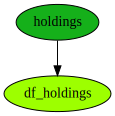

In [4]:
comp

So we can go ahead and calculate **df_holdings** and check that it looks correct. Computation objects have an attribute-based accessor, `v`, which allows us to see the value of any node. It also works great with the auto-complete in interactive environments, such as IPython Notebook.

In [5]:
comp.compute('df_holdings')
comp.v.df_holdings

,Type,Symbol,Qty,CostBasis
0,Equity,AVGO,126,22680.0
1,Equity,EVHC,349,22685.0
2,Equity,STT,287,22673.0
3,Equity,DAL,454,22700.0
4,Equity,DY,283,22640.0
5,Future,ESM7,-1,0.0
6,Cash,USD,2000,NaN


A quick sidenote: It is the nature of these examples that I present the computations in their complete state, with no mention of the struggle that it took to get them there. That's a shame, because one of the really great things about working with Loman is that you can iterate on a single node - even one in the middle of a calculation - without having to recalculate any of the upstream or downstream nodes if you don't want to. In this case, it doesn't make a huge amount of difference, but when dealing with large data sets and time-consuming calculations, it can be a boon not to have to wait a couple of minutes to see the results of your latest update to an intermediate calculation.

## Splitting the Holdings by Asset Type

Back to the main plot. We will need to source different market data for each type of asset that we hold, and perform different calculations to boot. To this end, we split **df_holdings** into three separate DataFrames, one for each asset type, in nodes **df_holdings_equity**, **df_holdings_future** and **df_holdings_cash**.

We use a single function for calculating each of the nodes, and provide different values to the `type` parameter. As before, the Loman knows that the df_holdings argument will be populated from the **df_holdings** node. We use the `kwds` parameter to `add_node` to tell Loman that the parameter `type` should be a constant, rather than taken from a node. Thus the **df_holdings_equity** node will be calculated using the **df_holdings** node, and the constant `'Equity'`, and so on.

In [6]:
def filter_df(df_holdings, type):
    return df_holdings[df_holdings.Type == type]
comp.add_node('df_holdings_equity', filter_df, kwds={'type': loman.C('Equity')})
comp.add_node('df_holdings_future', filter_df, kwds={'type': loman.C('Future')})
comp.add_node('df_holdings_cash', filter_df, kwds={'type': loman.C('Cash')})

As before, we can compute nodes and inspect the results to make sure they are as we expect:

In [7]:
comp.compute_all()
comp.v.df_holdings_equity

,Type,Symbol,Qty,CostBasis
0,Equity,AVGO,126,22680.0
1,Equity,EVHC,349,22685.0
2,Equity,STT,287,22673.0
3,Equity,DAL,454,22700.0
4,Equity,DY,283,22640.0


In [8]:
comp.v.df_holdings_future

,Type,Symbol,Qty,CostBasis
5,Future,ESM7,-1,0.0


In [9]:
comp.v.df_holdings_cash

,Type,Symbol,Qty,CostBasis
6,Cash,USD,2000,NaN


## Gathering Market Data

To do a portfolio valuation, and calculate exposure metrics, we will need market data. The market data we need will be different for each type of asset. We start first with the equity portfolio.

### Equity Prices from Yahoo

We add node **df_equity_yql_data_yahoo**, and we populate it by applying the function `get_yahoo_equity_data` to each Symbol in **df_holdings_equity**, the DataFrame with our equity holdings, in turn. The yahoo_finance library returns a dictionary, for each symbol, so we turn each of those into a row, and **df_equity_yql_data_yahoo** will contain a DataFrame.

In [10]:
import yahoo_finance

def get_yahoo_equity_data(symbol):
    s = yahoo_finance.Share(symbol)
    return pd.Series(s.data_set)

@loman.node(comp)
def df_equity_yql_data_yahoo(df_holdings_equity):
    return df_holdings_equity.Symbol.apply(get_yahoo_equity_data)

As before, we can compute and inspect the node to see what it contains. Yahoo returns a large number of fields, and we capture them all. For now, we will only use a small number of those fields, but there is no extra cost to capture them, and they may be useful for other calculations that we would want to add in the future - for example, we may want to calculate sets of alerts as prices fall below certain moving averages, say.

In [11]:
comp.compute_all()
comp.v.df_equity_yql_data_yahoo

,AfterHoursChangeRealtime,AnnualizedGain,Ask,AskRealtime,AverageDailyVolume,Bid,BidRealtime,BookValue,Change,ChangeFromFiftydayMovingAverage,...,StockExchange,Symbol,TickerTrend,TradeDate,TwoHundreddayMovingAverage,Volume,YearHigh,YearLow,YearRange,symbol
0,None,None,221.95,None,2400980,220.41,None,47.55,+0.51,2.30,...,NMS,AVGO,None,None,194.77,1533863,227.75,139.18,139.18 - 227.75,AVGO
1,None,None,None,None,1653080,None,None,57.91,+0.15,-4.19,...,NYQ,EVHC,None,None,54.35,1700248,82.66,53.12,53.12 - 82.66,EVHC
2,None,None,None,None,2260140,None,None,47.19,+0.04,4.75,...,NYQ,STT,None,None,78.02,2225627,85.38,50.60,50.60 - 85.38,STT
3,None,None,None,None,8545340,None,None,17.78,-0.04,-0.42,...,NYQ,DAL,None,None,47.42,6378922,52.76,32.60,32.60 - 52.76,DAL
4,None,None,None,None,650651,None,None,19.58,+0.89,9.52,...,NYQ,DY,None,None,85.42,415220,109.65,66.09,66.09 - 109.65,DY


### Scraping Equity Betas

We would also like betas for the equities in our portfolio. Unfortunately, Yahoo doesn't expose these through its YQL API, so we instead scrape the data directly from the page. Again, we'd like to strongly recommend using paid data sources to avoid this sort of hack. Nonetheless, this does demonstrate the power of the libraries available for Python, as well as showcasing Loman's ability to easily integrate multiple data sources.

We use the same strategy of iterating over each Symbol in **df_holdings_equity**, this time applying the function `scrape_yahoo_data` to get a web page and read beta from it. 

In [12]:
import requests, bs4

def scrape_yahoo_data(symbol):
    resp = requests.get('https://finance.yahoo.com/quote/{}?ltr=1'.format(symbol))
    soup = bs4.BeautifulSoup(resp.content, 'lxml')
    el = soup.find(attrs={'data-test': 'BETA-value'})
    beta = float(el.text)
    return pd.Series({'Symbol': symbol, 'Beta': beta})

@loman.node(comp)
def df_equity_scraped_data_yahoo(df_holdings_equity):
    return df_holdings_equity.Symbol.apply(scrape_yahoo_data)

And again, we quickly compute and inspect the result. 

In [13]:
comp.compute_all()
comp.v.df_equity_scraped_data_yahoo

,Beta,Symbol
0,1.12,AVGO
1,0.35,EVHC
2,1.29,STT
3,1.07,DAL
4,1.54,DY


### Futures Prices

The parsing of futures prices from scrapes of the CME's website is slightly more onerous, requiring the future code to be parsed from an attribute using a regex. To move the exposition along, we won't cover it in detail, but just show that the DataFrame of prices we obtain is sensible:

In [14]:
import numpy as np
import re
from dateutil import relativedelta

id_regex = re.compile('quotesFuturesProductTable1_(?P<Symbol>.{4})_(?P<Field>.*)')

def get_el_data(el):
    m = id_regex.match(el['id'])
    d = m.groupdict()
    d['Value'] = el.text
    return d

def try_float(x):
    try:
        return float(x)
    except:
        return np.nan

@loman.node(comp)
def df_future_prices():
    resp = requests.get('http://www.cmegroup.com/trading/equity-index/us-index/e-mini-sandp500.html')
    soup = bs4.BeautifulSoup(resp.content, 'lxml')
    els = soup.findAll('td', attrs={'id': id_regex})    
    df = pd.DataFrame([get_el_data(el) for el in els])
    df = df.set_index(['Symbol', 'Field']).Value.unstack()
    for col in ['change', 'high', 'last', 'low', 'open', 'volume']:
        df[col] = df[col].apply(try_float)    
    return df

In [15]:
comp.compute_all()
comp.v.df_future_prices

Field,change,high,highLowLimits,last,low,open,priorSettle,updated,volume
Symbol,,,,,,,,,
ESH8,NaN,NaN,2498.50 / 2260.50,NaN,NaN,NaN,2380.75,00:23:14 CT 02 May 2017,0.0
ESM7,-1.25,2388.25,2504.50 / 2266.50,2385.75,2384.25,2386.25,2387.00,01:30:12 CT 02 May 2017,NaN
ESM8,NaN,NaN,2499.50 / 2261.50,NaN,NaN,NaN,2381.75,00:20:46 CT 02 May 2017,0.0
ESU7,-1.25,2385.75,2502.00 / 2264.00,2383.25,2382.50,2383.75,2384.50,01:25:00 CT 02 May 2017,55.0
ESZ7,-0.75,2382.00,2500.50 / 2262.50,2382.00,2382.00,2382.00,2382.75,00:59:41 CT 02 May 2017,2.0


We also need some static data for futures. In this case we need two things: First, the contract unit i.e. the dollar amount of each point move in the index. And secondly, the beta, which in this case (glossing over technicalities) is 1, since the underlying of the future is the index itself. In a real system, this data would be stored in a database or security master system, which we could of course access from Loman. To keep this example self-contained, here we hardcode our static data, and insert it into a node **df_future_static_data**.

In [16]:
data = [
    ['ESM7', 50, 'USD', 1.],
    ['ESU7', 50, 'USD', 1.],
    ['ESZ7', 50, 'USD', 1.],
    ['ESH8', 50, 'USD', 1.],
    ['ESM8', 50, 'USD', 1.],
]
df = pd.DataFrame(data, columns=['Symbol', 'UnitAmount', 'UnitCurrency', 'Beta'])
comp.add_node('df_future_static_data', value=df)

## Calculating P&Ls

Finally, we come onto the interesting bit - using our holdings data and market data to calculate P&Ls and exposure measures.

We start with the equity portion of the portfolio. We'll add a new node **df_equity_pnl**, which will contain a DataFrame with a row for each holding we have, together with the market and other information that we want. This node will depend on the three relevant nodes **df_holdings_equity** (containing holdings data), **df_equity_yql_data_yahoo** (containing prices) and **df_equity_scraped_data_yahoo** (containing betas), and so these are the parameters of the function defining the node **df_equity_pnl**.

In the first part of the computation, we use Pandas merge functionality to join the tables, based on looking up Symbol in each table. We also take the opportunity to limit the set of columns taken from **df_equity_yql_data_yahoo**, and to rename columns to our liking.

In the second part of the computation, we calculate several measures. For example, intraday PNL is current value less value at the close. And we define an exposure metric called CurrentBetaAdjExposure, which is defined as Beta $\times$ Current Exposure (Current Exposure is just Current Value for equities).

As always, we check the results as we go.

In [17]:
@loman.node(comp)
def df_equity_pnl(df_holdings_equity, df_equity_yql_data_yahoo, df_equity_scraped_data_yahoo):
    # Merge DataFrames
    df = pd.merge(df_holdings_equity, df_equity_yql_data_yahoo[['Symbol', 'PreviousClose', 'LastTradePriceOnly']], 
                  how='left', on='Symbol')
    df.rename(columns={'PreviousClose': 'Close', 'LastTradePriceOnly': 'Last'}, inplace=True)
    for col in ['Close', 'Last']:
        df[col] = df[col].astype(float)
    df = pd.merge(df, df_equity_scraped_data_yahoo, how='left', on='Symbol')
    
    # Calculate Measures
    df['CloseValue'] = df.Qty * df.Close
    df['CurrentValue'] = df.Qty * df.Last
    df['PNL_Day'] = df.CurrentValue - df.CloseValue
    df['PNL_ITD'] = df.CurrentValue - df.CostBasis
    df['CurrentExposure'] = df.CurrentValue
    df['CurrentBetaAdjExposure'] = df.Beta * df.CurrentExposure
    return df
comp.compute_all()
comp.v.df_equity_pnl

,Type,Symbol,Qty,CostBasis,Close,Last,Beta,CloseValue,CurrentValue,PNL_Day,PNL_ITD,CurrentExposure,CurrentBetaAdjExposure
0,Equity,AVGO,126,22680.0,220.81,221.32,1.12,27822.06,27886.32,64.26,5206.32,27886.32,31232.6784
1,Equity,EVHC,349,22685.0,56.03,56.18,0.35,19554.47,19606.82,52.35,-3078.18,19606.82,6862.3870
2,Equity,STT,287,22673.0,83.90,83.94,1.29,24079.30,24090.78,11.48,1417.78,24090.78,31077.1062
3,Equity,DAL,454,22700.0,45.44,45.40,1.07,20629.76,20611.60,-18.16,-2088.40,20611.60,22054.4120
4,Equity,DY,283,22640.0,105.66,106.55,1.54,29901.78,30153.65,251.87,7513.65,30153.65,46436.6210


The process is very similar for futures. **df_future_pnl** is created by merging the holdings, price and static data in **df_holdings_future**, **df_future_prices** and **df_future_static_data** respectively. We again calculate each of the P&L and exposure measures that we would like to see, but note that the treatment for futures is different. For example, intraday P&L is calculated as $(\text{Last Price} - \text{Close Price}) \times \text{Quantity} \times \text{Contract Unit}$.

In [18]:
@loman.node(comp)
def df_future_pnl(df_holdings_future, df_future_prices, df_future_static_data):
    # Merge DataFrames
    df = pd.merge(df_holdings_future, df_future_prices[['priorSettle', 'last']], how='left', left_on='Symbol', right_index=True)
    df.rename(columns={'priorSettle': 'Close', 'last': 'Last'}, inplace=True)
    for col in ['Close', 'Last']:
        df[col] = df[col].astype(float)
    df = pd.merge(df, df_future_static_data, how='left', on='Symbol')
    
    # Calculate Measures
    df['PNL_Day'] = (df.Last - df.Close) * df.Qty * df.UnitAmount
    df['CloseValue'] = 0
    df['CurrentValue'] = df.PNL_Day 
    df['PNL_ITD'] = df.CurrentValue - df.CostBasis
    df['CurrentExposure'] = df.Last * df.Qty * df.UnitAmount
    df['CurrentBetaAdjExposure'] = df.Beta * df.CurrentExposure
    return df
comp.compute_all()
comp.v.df_future_pnl

,Type,Symbol,Qty,CostBasis,Close,Last,UnitAmount,UnitCurrency,Beta,PNL_Day,CloseValue,CurrentValue,PNL_ITD,CurrentExposure,CurrentBetaAdjExposure
0,Future,ESM7,-1,0.0,2387.0,2385.75,50,USD,1.0,62.5,0,62.5,62.5,-119287.5,-119287.5


The calculations for the cash component are more basic, as cash has no exposure by these measures:

In [19]:
@loman.node(comp)
def df_cash_pnl(df_holdings_cash):
    df = df_holdings_cash.copy()
    df['Close'] = np.nan
    df['Last'] = np.nan
    df['PNL_Day'] = df['PNL_ITD'] = 0.
    df['CloseValue'] = df['CurrentValue'] = df['CostBasis'] = df.Qty
    df['CurrentExposure'] = df['CurrentBetaAdjExposure'] = 0.
    df['Beta'] = 0
    return df
comp.compute_all()
comp.v.df_cash_pnl

,Type,Symbol,Qty,CostBasis,Close,Last,PNL_Day,PNL_ITD,CloseValue,CurrentValue,CurrentExposure,CurrentBetaAdjExposure,Beta
6,Cash,USD,2000,2000,NaN,NaN,0.0,0.0,2000,2000,0.0,0.0,0


Finally, we add a node **df_pnl**, where we take all the rows from the equity, future and cash P&L and exposure DataFrames in **df_equity_pnl**, **df_future_pnl** and **df_cash_pnl** respectively. This gives us a position-by-position P&L report.

In [20]:
@loman.node(comp)
def df_pnl(df_equity_pnl, df_future_pnl, df_cash_pnl):
    df = pd.concat([df_equity_pnl, df_future_pnl, df_cash_pnl])
    df = df[['Type', 'Symbol', 'Qty', 'Close', 'Last', 'CostBasis', 'CloseValue', 'CurrentValue', 'PNL_ITD', 'PNL_Day', 'Beta', 'CurrentExposure', 'CurrentBetaAdjExposure']]
    return df
comp.compute_all()
comp.v.df_pnl

,Type,Symbol,Qty,Close,Last,CostBasis,CloseValue,CurrentValue,PNL_ITD,PNL_Day,Beta,CurrentExposure,CurrentBetaAdjExposure
0,Equity,AVGO,126,220.81,221.32,22680.0,27822.06,27886.32,5206.32,64.26,1.12,27886.32,31232.6784
1,Equity,EVHC,349,56.03,56.18,22685.0,19554.47,19606.82,-3078.18,52.35,0.35,19606.82,6862.3870
2,Equity,STT,287,83.90,83.94,22673.0,24079.30,24090.78,1417.78,11.48,1.29,24090.78,31077.1062
3,Equity,DAL,454,45.44,45.40,22700.0,20629.76,20611.60,-2088.40,-18.16,1.07,20611.60,22054.4120
4,Equity,DY,283,105.66,106.55,22640.0,29901.78,30153.65,7513.65,251.87,1.54,30153.65,46436.6210
0,Future,ESM7,-1,2387.00,2385.75,0.0,0.00,62.50,62.50,62.50,1.00,-119287.50,-119287.5000
6,Cash,USD,2000,NaN,NaN,2000.0,2000.00,2000.00,0.00,0.00,0.00,0.00,0.0000


From there, various aggregations are possible. For example, we can easily see intraday P&L, and inception-to-date P&L:

In [21]:
comp.v.df_pnl.PNL_Day.sum()

424.299999999992

In [22]:
comp.v.df_pnl.PNL_ITD.sum()

9033.669999999995

As well as seeing our exposure, and beta-adjusted exposure metrics across the whole portfolio.

In [23]:
comp.v.df_pnl[['CurrentExposure', 'CurrentBetaAdjExposure']].sum()

CurrentExposure            3061.6700
CurrentBetaAdjExposure    18375.7046
dtype: float64

We could even put the aggregated data itself into new nodes.

## Final Thoughts

The first thing to point out is that our computation is now both reasonably complex, but very logically laid out:

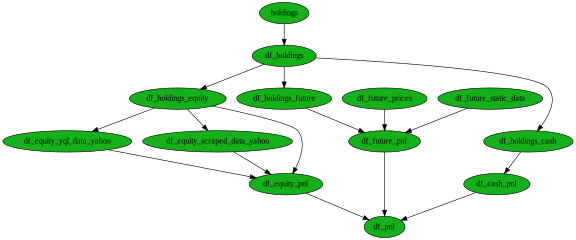

In [24]:
comp.draw(graph_attr={'size': '"8,6"'})

This is serves a practical purpose. Code typically spends the bulk of its life being maintained, so it is important to make that maintenance as easy and fast as possible. Returning to this after several months, it takes a time to reacquaint with even a modest amount of code, while the logical structure and visualization capabilities offered by Loman make it easy to see how a computation occurs.

There are also benefits when we are first creating code. Because Loman keeps track of state for us, as we interactively add nodes (and possibily take several iterations to get them correct), we do not have to re-run upstream dependencies. Contrast this with a writing a program by adding sub-routines or sections of code. Each re-run would necessitate fetching data from several external websites, and by the end, even in this small case, the process of trying out new iterations becomes quite onerous.

Of course there are other possibilities. An interactive environment such as IPython Notebook requires us to manually keep track ourselves of what needs to be re-run each time. Or a program that serializes data from external websites to disk and then reads in the cached copy also imposes a substantial cognitive load keeping track of that cache.

Our solution is extensible. It is easy to add new asset types, new measures, or new classifications to cover more complex portfolios, and create more detailed reports. Also, we can combine with other data sources to create entirely new reports - for example, it is easy to imagine using earnings announcement calendars to create a node with a list of equities reporting earnings in the next week, which could be used to provide alerts. Or we could progarm a node to show how near our portfolio is to risk or compliance limits.

For real-time use, Loman's ability to track state allows us to update different inputs at different cadences. For example, we might update the equity and price nodes every tick, or every few seconds, but update semi-static data less frequently. 

We can also control output cadence by specifying which nodes to calculate, when. We only produce one set of results here, but consider if we had a valuation or risk model that we wanted to use, but which was slow to calculate. We could still calculate P&L at a relatively high frequency, which calculating the more time-consuming model every few minutes, say.

Finally, our solution is potentially usable in a variety of different contexts. We might have a batch system using this computation graph, to produce daily, or periodic intraday valuations centrally, while the investment team managing a particular portfolio might appreciate the ability to run the same computation graph on their portfolios and model portfolios whenever they desire.

That brings us to the end of this example. We looked at how to use Loman to create a basic valuation system for a limited portfolio. In doing so, we explored several tangible benefits that we hope make life easier for quant practitioners. If anything is unclear in this example, feel free to contact the authors through the [Loman Forum on Google Groups](https://groups.google.com/forum/#!forum/loman-python).